In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

# Examples



## Creating Compatible Primary Keys


### Simple String Manipulation

Manipulating strings directy, without using regular expressions, can get us a long way. As an example, we will develop some code to clean the county names, where the code does not use regular expressions. 

Let's create some sample data that has all of the issues that we want to fix in a few county names. Recall that we want to:


1. Change all letters to lower case.
1. Drop county and parish from the end of the string.
1. Change '&' to 'and'
1. Drop all periods
1. Eliminate all spaces/blanks

The following strings have all of these features that need fixing.

In [2]:
county_ex = [
    'De witt County', 
    'Lac qui Parle County', 
    'St. John the Baptist Parish', 
    'Stone County', 
    'Lewis & Clark County'
]

Typically, we want to convert the letters to lower case first because then we know that we are only working with lower case.

In our example, "county" and "parish" are both 6 letters long so we need not do anything fancy to eliminate this word from each string. We can simply drop the last 6 characters.

Then we can go through the characters in each string, one at a time, and eliminate the blanks and periods and replace the "&" with "and".

The code below takes care of these string manipulations:


In [3]:
final = []
for s in county_ex:
    lower = s.lower()
    wo_county = lower[:-7]
    def dropchange(l):
        if l == "&":
            return "and"
        elif l == " " or l == ".":
            return "" 
        else:
            return l
    final_word = "".join([dropchange(l) for l in wo_county])
    final.append(final_word)
print(final)

['dewitt', 'lacquiparle', 'stjohnthebaptist', 'stone', 'lewisandclark']


Here's an alternative approach.

In [4]:
final = []
for s in county_ex:
    lower = s.lower()
    without_county = lower[:-7]
    def amptoand(l):
        if l == "&":
            return "and"
        else:
            return l
    final_word = "".join([amptoand(l) for l in without_county if l != "." and l != " "])
    final.append(final_word)
print(final)

['dewitt', 'lacquiparle', 'stjohnthebaptist', 'stone', 'lewisandclark']


Why did we eliminate all blanks from the names, rather than eliminate from De Witt County? We looked at only a few records and can imagine that there are other cases where we want to drop a blank. Also, removing all of the blanks could make the county names easier to work with in general.  Is there a downside to dropping the spaces? If a county is no longer uniquely identified without the blanks in its name, then that could be a problem. 


### Python list comprehension

We can instead use Python list comprehension to make the changes to `county_ex`.

In [5]:
cleaned_cty = [
    w.lower()[:-7] # fancy indexing
    .replace(".","")
    .replace("&","and")
    .replace(" ", "") 
    for w in county_ex
]
print(cleaned_cty)

['dewitt', 'lacquiparle', 'stjohnthebaptist', 'stone', 'lewisandclark']


### Data frame

We can also work with the county name as a column in a dataframe and clean it.
Below are two approaches to create a data frame from `county_ex`.

In [6]:
df = pd.DataFrame(pd.Series(county_ex, name="County"))
df

,County
0,De witt County
1,Lac qui Parle County
2,St. John the Baptist Parish
3,Stone County
4,Lewis & Clark County


In [7]:
df = pd.DataFrame(data = county_ex, columns=["County"])
df

,County
0,De witt County
1,Lac qui Parle County
2,St. John the Baptist Parish
3,Stone County
4,Lewis & Clark County


If we want to return to the original format we can get the county strings back out with:

In [8]:
df['County']

0                 De witt County
1           Lac qui Parle County
2    St. John the Baptist Parish
3                   Stone County
4           Lewis & Clark County
Name: County, dtype: object

### Python list comprehension

Lastly, we use the string manipulation available for Pandas dataframes to perform the same cleaning. Rather than loop through each character in the string one at a time, we use `str` to work on the string. The method `replace` takes regular expressions as arguments. An example below is "county|parish" this pattern will match either the characters "county" or the characters "parish" and if `replace` finds a match anywhere in the string, it will replace it with "", i.e., it will drop it.  

In [9]:
(
    df['County'].str.lower()
    .str.replace("county", "")
    .str.replace("parish", "")
    .str.replace(".","")
    .str.replace("&","and")
    .str.replace(" ", "")
)

0              dewitt
1         lacquiparle
2    stjohnthebaptist
3               stone
4       lewisandclark
Name: County, dtype: object

Below is a more compact version that consolidates the replacements using metacharacters in regular expressions. For example, An example, the "county|parish" pattern matches either the characters "county" or the characters "parish" so if `replace` finds a match anywhere in the string, it will replace these 6 characters with "", i.e., they will be dropped. 

Also, the pattern "[. ]" says that either a period or a blank are to be treated equivalently because they are within the square brackets. Now, if either a blank or a period is found, then it will be replaced with "" (that is, it will be dropped).

In [10]:
(
    df['County'].str.lower()
    .str.replace("county|parish","")
    .str.replace("[. ]","")
    .str.replace("&","and")
)

0              dewitt
1         lacquiparle
2    stjohnthebaptist
3               stone
4       lewisandclark
Name: County, dtype: object

We have introduced some concepts related to pattern matching, such as | and [ ]. We will cover more in detail in the examples in class slides.

## Web Logs

In our next example, we process strings that have some structure, but not enough to always finr values between commas, say, or in fixed positions in all reacords. We can get a long way with simple string manipulation in this example too, but we will demonstrate how powerful a regular expression can be in extracting fields from strings.

These data are logs from a web site. Again, we use a small data set to demonstrate how we might process the file, but we don't actually process and analyze the full dataset.

In [11]:
ls -lh data

total 202472
-rwxr-xr-x@ 1 nolan  staff    89M Sep  9 12:01 141WebLog.log*
-rw-r--r--  1 nolan  staff   400B Sep 18 18:06 smallLog.txt
-rw-r--r--  1 nolan  staff   9.9M Sep 18 19:48 stateoftheunion1790-2017.txt


The sample file has only two records as we see in the call to `head` below.

In [12]:
!head data/smallLog.txt

169.237.46.168 - - [26/Jan/2014:10:47:58 -0800] "GET /stat141/Winter04 HTTP/1.1" 301 328 "http://anson.ucdavis.edu/courses/"  "Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.0; .NET CLR 1.1.4322)”
169.237.46.168 - - [26/Jan/2014:10:47:58 -0800] "GET /stat141/Winter04/ HTTP/1.1" 200 2585 "http://anson.ucdavis.edu/courses/" "Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.0; .NET CLR 1.1.4322)"



We want to read each line of the file in as a string and then process the strings to create variables. We use `readlines` to do this.

In [13]:
with open("data/smallLog.txt", "r") as f:
    lines = f.readlines()
print(len(lines))
print(lines[0])

3
169.237.46.168 - - [26/Jan/2014:10:47:58 -0800] "GET /stat141/Winter04 HTTP/1.1" 301 328 "http://anson.ucdavis.edu/courses/"  "Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.0; .NET CLR 1.1.4322)”



We can place `lines` in a dataframe and work with the strings as a column in the dataframe.

In [14]:
df = pd.DataFrame(pd.Series(lines, name="raw"))
df

,raw
0,169.237.46.168 - - [26/Jan/2014:10:47:58 -0800...
1,169.237.46.168 - - [26/Jan/2014:10:47:58 -0800...
2,\n


Each log entry contains a lot of information such as the:

* Page visited
* Date and time of visit
* Browser used
* IP address 

When we examine the records, we see that there are certain characters that separate the fields. In our two sample records some of the pieces of information appear in the same location, but we don't want to rely on that always being the case. For example, the IP address at the beginning of the string need not always be 14 characters long. It might be 15 characters if all four of the numbers have 3 digits. This would then shift the rest of the information in the string. Instead, we want to key on the separators to locate the information.

Sometimes these are dashes, other times they are square brackets, commas, or colons. Let's consider the task of extracting the day, month, and year each as a string. One way to do this is to split the string into pieces. We can do this with the `split` method. 

We first split the string many times over to zoom in on the substring(s) of interest. That is, the date appears between `[` and `]`

Let's first split the string at the left square brackets. Notice that the square brackets are "eaten" by the splitting process.

In [15]:
date = df['raw'].str.split(r'[').str
date[0]

0    169.237.46.168 - - 
1    169.237.46.168 - - 
2                     \n
Name: raw, dtype: object

In [16]:
date[1]

0    26/Jan/2014:10:47:58 -0800] "GET /stat141/Wint...
1    26/Jan/2014:10:47:58 -0800] "GET /stat141/Wint...
2                                                  NaN
Name: raw, dtype: object

The second substring contains the date. If we split the second substring at colons then the first of its substrings will contain the day, month, and year. That is, 

In [17]:
date2 = date[1].str.split(r':').str[0]
print(date2)

0    26/Jan/2014
1    26/Jan/2014
2            NaN
Name: raw, dtype: object


In [18]:
(df['raw']
 .str.split(r'[').str[1]
 .str.split(r':').str[0]
 .str.split(r'/').str[0:3]
)

0    [26, Jan, 2014]
1    [26, Jan, 2014]
2                NaN
Name: raw, dtype: object

In [19]:
date3 = date2.str.split(r'/').str[0:3]
df['day'] = date3.str[0]
df['mon'] = date3.str[1]
df['Yr'] = date3.str[2]
df

,raw,day,mon,Yr
0,169.237.46.168 - - [26/Jan/2014:10:47:58 -0800...,26,Jan,2014
1,169.237.46.168 - - [26/Jan/2014:10:47:58 -0800...,26,Jan,2014
2,\n,NaN,NaN,NaN


Lastly, we can split this string, e.g., "26/Jan/2014", on the forward slash and assign each of the 3 resulting substrings to day, month, and year variables in `df1`.

We can perform all of these splits at once with

In [20]:
date_pieces = (df['raw']
               .str.split(r'[').str[1]
               .str.split(r':').str[0]
               .str.split(r'/').str[0:3]
              )
print(date_pieces)
df['day'] = date_pieces.str[0]
df['mon'] = date_pieces.str[1]
df['Yr'] = date_pieces.str[2]
df

0    [26, Jan, 2014]
1    [26, Jan, 2014]
2                NaN
Name: raw, dtype: object


,raw,day,mon,Yr
0,169.237.46.168 - - [26/Jan/2014:10:47:58 -0800...,26,Jan,2014
1,169.237.46.168 - - [26/Jan/2014:10:47:58 -0800...,26,Jan,2014
2,\n,NaN,NaN,NaN


However with regular expressions, we can split on any of the 3 characters, '[' or ':' or "/", in one call to `split`. That is, we can split the string on 3 equivalent and then select the desired substrings. We do this as follows.

In [21]:
df1 = pd.DataFrame(pd.Series(lines, name="raw"))
date = df1['raw'].str.split(r'[\[/:]').str[1:4]
df1['day'] = date.str[0]
df1['mon'] = date.str[1]
df1['yr'] = date.str[2]
df

,raw,day,mon,Yr
0,169.237.46.168 - - [26/Jan/2014:10:47:58 -0800...,26,Jan,2014
1,169.237.46.168 - - [26/Jan/2014:10:47:58 -0800...,26,Jan,2014
2,\n,NaN,NaN,NaN


In the above call to `split` we passed a regular expression, '[\\[/:]'. This is a special pattern.  The outer brackets indicate that the characters within are to be treated equivalently. The literals are within the brackets; these are the left bracket, forward slash, and colon.  Equivalent characters means: "when any of these are found" split the string. Notice the backslash preceeding the left bracket withing the outer brackets. This is a special character that indicates that the [ is to be treated as the literal backslash, i.e., it is not a special character for the regex engine. We delve into regular expressions in greater depth in the next example.

## Food Safety




In [22]:
vio = pd.read_csv("../../hw/hw2/data/violations.csv")

In [23]:
new_date = vio['date'].apply(lambda d: pd.datetime.strptime(str(d),'%Y%m%d'))
vio['year']  = new_date.dt.year

In [24]:
vio = vio[vio['year'] == 2016].copy()

In [25]:
vio['description'].value_counts().head(20)

Unclean or degraded floors walls or ceilings                                 844
Unapproved or unmaintained equipment or utensils                             527
Moderate risk food holding temperature                                       491
Inadequate and inaccessible handwashing facilities                           430
Wiping cloths not clean or properly stored or inadequate sanitizer           413
Inadequately cleaned or sanitized food contact surfaces                      400
Improper food storage                                                        399
Food safety certificate or food handler card not available                   354
Foods not protected from contamination                                       294
Moderate risk vermin infestation                                             287
Unclean nonfood contact surfaces                                             285
Low risk vermin infestation                                                  265
Permit license or inspection

In [26]:
len(vio['description'].value_counts())

4688

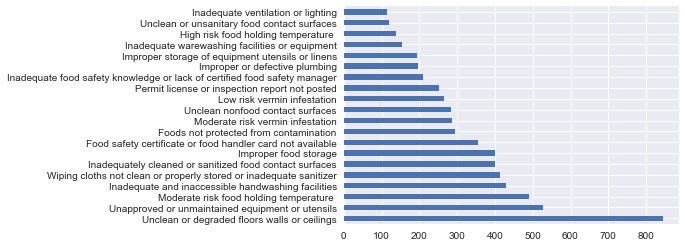

In [27]:
vio['description'].value_counts().head(20).plot(kind='barh')

In [28]:
vio['description'].value_counts().tail(10)

Unclean nonfood contact surfaces  [ date violation corrected: 6/22/2016 ]                                         1
High risk vermin infestation  [ date violation corrected: 10/27/2016 ]                                            1
Improper storage use or identification of toxic substances  [ date violation corrected: 5/26/2016 ]               1
Other low risk violation  [ date violation corrected: 3/23/2016 ]                                                 1
Unclean or degraded floors walls or ceilings  [ date violation corrected: 2/1/2016 ]                              1
Inadequate procedures or records for time as a public health control   [ date violation corrected: 2/19/2016 ]    1
Unclean hands or improper use of gloves  [ date violation corrected: 8/15/2016 ]                                  1
Improper cooling methods  [ date violation corrected: 4/20/2016 ]                                                 1
Inadequately cleaned or sanitized food contact surfaces  [ date violatio

Remove the [ date violation corrected ...] piece

In [29]:
vio['desc'] = vio['description'].str.replace("\[.*\]","").str.strip()

Now let's check how many unique violation descriptions we have

In [30]:
len(vio['desc'].value_counts())

64

In [31]:
vio['desc'].value_counts().head(20)

Unclean or degraded floors walls or ceilings                                 1536
Moderate risk food holding temperature                                       1188
Inadequate and inaccessible handwashing facilities                           1097
Unapproved or unmaintained equipment or utensils                             1011
Inadequately cleaned or sanitized food contact surfaces                       976
Wiping cloths not clean or properly stored or inadequate sanitizer            930
Improper food storage                                                         814
Foods not protected from contamination                                        764
High risk food holding temperature                                            732
Moderate risk vermin infestation                                              681
Food safety certificate or food handler card not available                    605
Unclean nonfood contact surfaces                                              573
Permit license o

In [32]:
vio['desc'].value_counts().tail(20)

Food in poor condition                                               15
Sewage or wastewater contamination                                   14
Unapproved  living quarters in food facility                         13
No plan review or Building Permit                                    13
Inadequate HACCP plan record keeping                                 12
Unapproved food source                                               12
Unpermitted food facility                                            11
No person in charge of food facility                                 11
Other high risk violation                                            10
Non service animal                                                    8
Reservice of previously served foods                                  4
Improper cooking time or temperatures                                 4
Noncompliance with Gulf Coast oyster regulation                       3
Improperly washed fruits and vegetables                         

In [33]:
# pd.get_dummies(vio['desc'])

In [34]:
regex = re.compile(r"clean|sanitary")

In [35]:
%%timeit
vio['desc'].str.contains(regex)

10 loops, best of 3: 40.6 ms per loop


In [36]:
%%timeit
vio['desc'].str.contains(r"clean|sanitary")

10 loops, best of 3: 27.8 ms per loop


### Derive variables that indicate violations

Let's create some variables that capture the essence of a type of violation. We identified violations related to:

* vermin
* risk
* walls, ceilings, floors, and nonfood surfaces
* food surfaces
* hands, gloves, hair, nails

And more.

Let's begin by creating a variable related to cleanliness. The regular expression below matches on "clean" or on "sanit". Why do we use "clean" rather than unclean? Why do we use "sanit" rather than unsanitary?

In [37]:
vio['isClean'] = vio['desc'].str.contains(r"clean|sanit")

Any violation with "clean" in the description will be about a cleanliness violation. We do not need to search for "unclean" or "not clean" or some other description that indicates there is a violation related to being clean. The same goes for "sanit", it will find not sanitary, unsanitary, and unsanitized, etc.

Next we look for violations that contain both "surface" and "\Wfood". This means that there is a violation related to the food surface. Why do we use the meta character "\W"? To avoid matching on words such as "nonfood" and so pick up issues with nonfood surfaces.

In [38]:
surface = vio['desc'].str.contains(r"surface")
food = vio['desc'].str.contains(r"\Wfood")
vio['isFoodSurface'] = (surface & food)

Next we create an ordinal variable that measures whether a violation is no risk (0), low risk (1), medium risk (2) or high risk (3). We first create 3 logical variables to to represent low, medium and high risk and then combine them to get an ordinal variable. Why is it ordinal and not quantitative?   

In [39]:
vio['isHighRisk'] = vio['desc'].str.contains(r"high risk")
vio['isMedRisk'] = vio['desc'].str.contains(r"medium risk")
vio['isLowRisk'] = vio['desc'].str.contains(r"low risk")
#create risk which is 1 2 3 for low medium or high
vio["risk"] = vio['isLowRisk'] + 2*vio['isMedRisk'] + 3*vio['isHighRisk']

In [ ]:
A few more variables for types of violations.

In [40]:
vio['isVermin'] = vio['desc'].str.contains(r"vermin")
vio['isStorage'] = vio['desc'].str.contains(r"thaw|cool|therm|storage")
vio['isDisplayPermit'] = vio['desc'].str.contains(r"certificate|permit")
vio['isNonFoodSurface'] = vio['desc'].str.contains(r"wall|ceiling|floor|nonfood surface")
vio['isHuman'] = vio['desc'].str.contains(r"hand|glove|hair|nail")

### Aggregate by business and Date

In [69]:
features = vio.groupby(['business_id', 'date']).aggregate({
        "isClean": sum,
        "isFoodSurface": sum,
        "isVermin": sum,
        "isStorage": sum,
        "isDisplayPermit": sum,
        "isNonFoodSurface": sum,
        "isHuman": sum,
        "isHighRisk": sum,
        "risk": max
    })
features.head()

isClean  isFoodSurface  isVermin  isStorage  \
business_id date                                                    
10          20160503      0.0            0.0       1.0        1.0   
19          20160513      1.0            0.0       0.0        0.0   
24          20160311      2.0            0.0       0.0        0.0   
            20161005      1.0            0.0       0.0        0.0   
31          20160816      0.0            0.0       0.0        3.0   

                      isDisplayPermit  isNonFoodSurface  isHuman  isHighRisk  \
business_id date                                                               
10          20160503            False               0.0      0.0       False   
19          20160513             True               1.0      1.0       False   
24          20160311            False               2.0      0.0       False   
            20161005            False               1.0      0.0       False   
31          20160816            False               0.0      1.0       False   

                      risk  
business_id date            
10          20160503     0  
19          20160513     0  
24          20160311     0  
            20161005     0  
31          20160816     0

In [70]:
a = vio.groupby(['business_id', 'date'])[['isClean', 'isFoodSurface', 'isVermin',
                                           'isStorage', 'isDisplayPermit', 'isHuman',
                                          'isNonFoodSurface', 'isHighRisk',]].sum()
b = vio.groupby(['business_id', 'date'])[['risk']].max()

features = a.join(b)

In [77]:
features = vio.groupby(['business_id', 'date'])[['isClean', 'isFoodSurface', 'isVermin',
                                                'isStorage', 'isDisplayPermit', 'isHuman',
                                                'isNonFoodSurface', 'isHighRisk']].sum()
features.head()

isClean  isFoodSurface  isVermin  isStorage  \
business_id date                                                    
10          20160503      0.0            0.0       1.0        1.0   
19          20160513      1.0            0.0       0.0        0.0   
24          20160311      2.0            0.0       0.0        0.0   
            20161005      1.0            0.0       0.0        0.0   
31          20160816      0.0            0.0       0.0        3.0   

                      isDisplayPermit  isHuman  isNonFoodSurface  isHighRisk  
business_id date                                                              
10          20160503              0.0      0.0               0.0         0.0  
19          20160513              1.0      1.0               1.0         0.0  
24          20160311              0.0      0.0               2.0         0.0  
            20161005              0.0      0.0               1.0         0.0  
31          20160816              0.0      1.0               0.0         0.0

In [78]:
ins = pd.read_csv("../../hw/hw2/data/inspections.csv").set_index(['business_id', 'date'])
ins.head()

score     type
business_id date                    
10          20160503     82  routine
            20140729     94  routine
            20140114     92  routine
19          20160513     94  routine
            20141110     94  routine

In [79]:
ins.join(features).head()

score     type isClean isFoodSurface isVermin isStorage  \
business_id date                                                                
10          20140114     92  routine     NaN           NaN      NaN       NaN   
            20140729     94  routine     NaN           NaN      NaN       NaN   
            20160503     82  routine       0             0        1         1   
19          20140214     94  routine     NaN           NaN      NaN       NaN   
            20141110     94  routine     NaN           NaN      NaN       NaN   

                     isDisplayPermit isHuman isNonFoodSurface isHighRisk  
business_id date                                                          
10          20140114             NaN     NaN              NaN        NaN  
            20140729             NaN     NaN              NaN        NaN  
            20160503               0       0                0          0  
19          20140214             NaN     NaN              NaN        NaN  
            20141110             NaN     NaN              NaN        NaN

In [82]:
features = vio.groupby(['business_id', 'date'], as_index=False)[['isClean', 'isFoodSurface', 
                                                                 'isVermin', 'isStorage', 
                                                                 'isDisplayPermit', 'isHuman',
                                                                 'isNonFoodSurface', 'isHighRisk']].sum()
features.head()

,business_id,date,isClean,isFoodSurface,isVermin,isStorage,isDisplayPermit,isHuman,isNonFoodSurface,isHighRisk
0,10,20160503,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,19,20160513,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
2,24,20160311,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
3,24,20161005,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,31,20160816,0.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0


In [83]:
ins = pd.read_csv("../../hw/hw2/data/inspections.csv")
ins.head()

,business_id,score,date,type
0,10,82,20160503,routine
1,10,94,20140729,routine
2,10,92,20140114,routine
3,19,94,20160513,routine
4,19,94,20141110,routine


In [84]:
joined_data = pd.merge(features, ins, on=['business_id', 'date'])
joined_data.head()

,business_id,date,isClean,isFoodSurface,isVermin,isStorage,isDisplayPermit,isHuman,isNonFoodSurface,isHighRisk,score,type
0,10,20160503,0,0,1,1,0,0,0,0,82,routine
1,19,20160513,1,0,0,0,1,1,1,0,94,routine
2,24,20160311,2,0,0,0,0,0,2,0,96,routine
3,24,20161005,1,0,0,0,0,0,1,0,98,routine
4,31,20160816,0,0,0,3,0,1,0,0,84,routine


In [85]:
feature_names = ['isClean', 'isHighRisk', 'isVermin', 'isHuman',
                 'isStorage', 'isFoodSurface', 'isNonFoodSurface', 'isDisplayPermit']
import sklearn.linear_model as lm
model = lm.LinearRegression()
model.fit(joined_data[feature_names], joined_data['score'])
model.coef_


array([-2.31378006, -8.34940828, -4.57556742, -4.56776883, -3.62436167,
       -3.71635214,  0.32897934,  2.82057907])

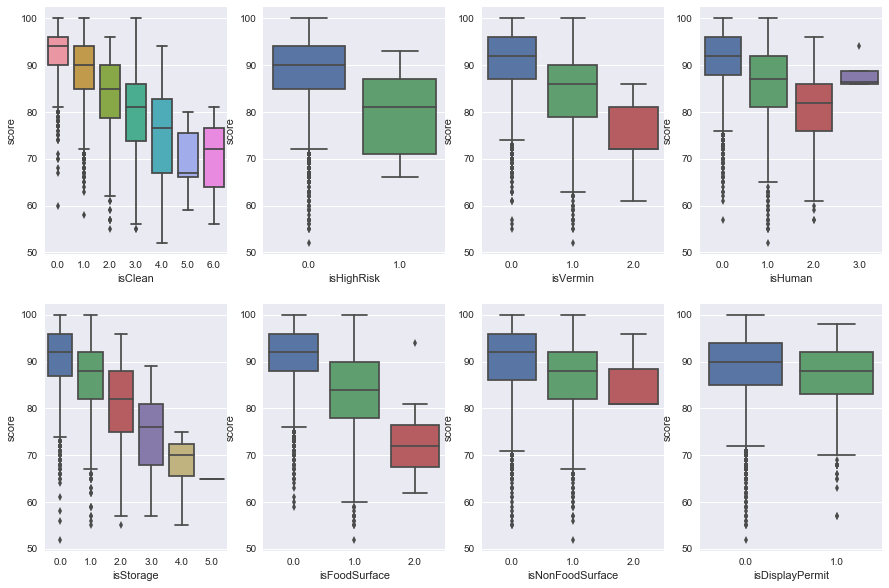

In [86]:
plt.figure(figsize=(15,10))
i = 1
for f in feature_names:
    plt.subplot(2, 4, i)
    sns.boxplot(y="score", x=f, data=joined_data)
    i += 1
#plt.savefig("violationBoxplts.pdf")

We can see from these boxplots that not having a permit displayed has little impact on the score. Violations that involve the improper storage of food or the unsanitary handling of food by people and vermin reduce the score. Multiple violations reduce the score even more.

## State of the union address

We have the text from all of the state of the union addresses. 

In [94]:
with open("data/stateoftheunion1790-2017.txt", "r") as f:
    text = f.read()

Recall that the speeches are separated by \*\*\*. We can separate the speeches by splitting on 3 asterisks. 

In [95]:
records = text.split("***")

After the \*\*\*, a speech is formatted as
```

State of the Union Address
George Washington
January 8, 1790

Fellow-Citizens of the Senate and House of Representatives:

I embrace with great satisfaction the opportunity which now presents itself...
```
If we split on new lines, i.e., \n then we can extract the name and date easily.
The rest of the lines can be joined together into one string containing the text of the speech.

In [96]:
def extract_parts(line):
    parts = line.split("\n")
    name = parts[3].strip()
    date = parts[4].strip()
    text = "\n".join(parts[5:]).strip()
    return [name, date, text]

df = pd.DataFrame([extract_parts(l) for l in records[1:]], columns=["Name", "Date", "Text"])
df.head()

,Name,Date,Text
0,George Washington,"January 8, 1790",Fellow-Citizens of the Senate and House of Rep...
1,George Washington,"December 8, 1790",Fellow-Citizens of the Senate and House of Rep...
2,George Washington,"October 25, 1791",Fellow-Citizens of the Senate and House of Rep...
3,George Washington,"November 6, 1792",Fellow-Citizens of the Senate and House of Rep...
4,George Washington,"December 3, 1793",Fellow-Citizens of the Senate and House of Rep...


We perform a few simple text cleaning tasks. We convert characters to lower case, eliminate the new lines, and drop all punctuation.

In [97]:
df['clean text'] = (
    df['Text']
    .str.replace("\n", " ")
    .str.lower()
    .str.replace(r"[^a-z\s]", " ")
)
df.head()

,Name,Date,Text,clean text
0,George Washington,"January 8, 1790",Fellow-Citizens of the Senate and House of Rep...,fellow citizens of the senate and house of rep...
1,George Washington,"December 8, 1790",Fellow-Citizens of the Senate and House of Rep...,fellow citizens of the senate and house of rep...
2,George Washington,"October 25, 1791",Fellow-Citizens of the Senate and House of Rep...,fellow citizens of the senate and house of rep...
3,George Washington,"November 6, 1792",Fellow-Citizens of the Senate and House of Rep...,fellow citizens of the senate and house of rep...
4,George Washington,"December 3, 1793",Fellow-Citizens of the Senate and House of Rep...,fellow citizens of the senate and house of rep...


We can then use `sklearn` to create a word vector for each speech, which contains the counts of all words in a speech. By all words, we mean the set of all unique words used across all 226 speeches.  We can think of each word vector as a record so we have 226 records and thousands of variables (word counts). 


We can try to examine the relationship between speeches by reducing the dimensionality of the data.  We take an approach that is a kind of Principle Component Analysis for word vectors. Specifically, we measure the distance between speeches via a metric on the word vectors. This metric normalizes by the rarity of a word. 

In [104]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer()
tfidf = vec.fit_transform(df['clean text'])

This gives us a 226 by 226 matrix of the distances between all pairs of speeches. Then we use SVD to decompose the matrix and plot the first two column vectors of the resulting decomposition (these are similar in nature to the first two principle components).

In [105]:
np.random.seed(42)
import scipy as sp
(u, s, vt) = sp.sparse.linalg.svds(tfidf, k=2)

In [106]:
df['Year'] = df['Date'].str[-4:].astype('int')
df['x'] = u[:,0]
df['y'] = u[:,1]

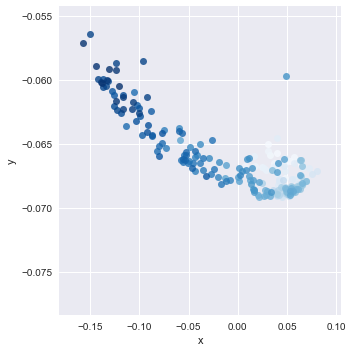

In [111]:
sns.lmplot(x = 'x', y = 'y', data = df, hue='Year', legend=False, 
           fit_reg=False, palette="Blues")
plt.savefig("SOTUspeeches.pdf")

In [108]:
!pip install plotly

In [109]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

In [110]:
colors = np.array(["rgba({0},{1},{2},1)".format(*c) for c in sns.color_palette("Blues", len(df))])
colors[-1] = "rgba(.99,.5,.2,1.)"
py.iplot([go.Scatter(x = df['x'], y = df['y'], mode='markers', marker=dict(color=colors), text=df['Name'])])


Each point represents a speech. Notice that the speeches are roughly align chronologically. Speeches long ago are more similar to one another than current speeches. The most unusual speech is by Herbert Hoover. George Bush also has a few unusual speeches. Trumps speech is close to ealier speeches by Ronald Reagan and George Bush and Bill Clinton.